# Regularized Regression

In [40]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available 
# on an “as is,” “as available,” and “with all faults” basis, solely for 
# illustrative purposes, and without warranty or representation of any kind. 
# This solution is experimental, unsupported and provided solely for your 
# convenience. Your use of it is subject to your agreements with Google, as 
# applicable, and may constitute a beta feature as defined under those 
# agreements.  To the extent that you make any data available to Google in 
# connection with your use of the solution, you represent and warrant that you 
# have all necessary and appropriate rights, consents and permissions to permit 
# Google to use and process that data.  By using any portion of this solution, 
# you acknowledge, assume and accept all risks, known and unknown, associated 
# with its usage, including with respect to your deployment of any portion of 
# this solution in your systems, or usage in connection with your business, 
# if at all.
###########################################################################

## 0) Dependencies

In [41]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'db-platform-sol' #add proj name and dataset

In [42]:
import requests
import io
import os
import datetime
import logging

# Google credentials authentication libraries
from google.colab import auth

!pip install --upgrade -q gspread 
import gspread

from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

# data processing libraries
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
import pandas_gbq
import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, LeavePOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error




# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Calculating Relative Importance
!pip install relativeImp
from relativeImp import relativeImp



# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics


magics.context.project = project_name  #update your project name 

client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## 1) Import dataset

In [43]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [44]:
%%bigquery df
SELECT *
FROM `db-platform-sol.RBA_demo.cleaned_data_`; #update with project name

In [45]:
df.head()

,x16Lag0Alpha1_0Decay0_9,x17Lag2Alpha0_6Decay0_9,x26Lag4Alpha0_6Decay0_6,x27Lag0Alpha1_0Decay0_9,x28Lag1Alpha0_6Decay0_6,x29Lag13Alpha0_6Decay0_6,x32Lag0Alpha0_6Decay0_9,x33Lag13Alpha0_6Decay1_0,x34Lag6Alpha1_0Decay1_0,x35Lag0Alpha0_6Decay0_9,x36Lag10Alpha1_0Decay0_7,x37Lag0Alpha0_6Decay0_8,x38Lag0Alpha0_6Decay1_0,x39Lag0Alpha1_0Decay0_9,x40Lag11Alpha1_0Decay0_8,x41Lag6Alpha0_8Decay1_0,x42Lag0Alpha0_8Decay0_7,x43Lag13Alpha0_7Decay0_6,x44Lag0Alpha0_6Decay0_9,x45Lag0Alpha0_8Decay1_0,x46Lag0Alpha0_6Decay0_9,y1
0,1.047345,3.385010,0.795715,-0.756770,-1.147226,-1.482503,3.055411,1.079540,-0.044908,-0.849554,-0.055398,-0.977477,1.955145,0.007262,-0.727261,0.942207,4.889252,-1.201553,-1.032766,3.662337,2.810573,2156
1,0.833003,3.295575,0.791107,-0.680353,-1.147226,-1.123241,2.834886,1.080038,-0.195059,-2.012361,-0.055398,-1.457682,1.422204,-1.920899,-1.028659,0.664657,1.592647,-1.201553,-0.322160,3.507570,3.095088,2298
2,0.945735,2.047934,0.851277,-0.727922,-1.147226,-0.898399,2.347238,-0.622938,-0.161586,-2.128642,-0.055398,-1.566067,1.840219,-1.894477,-0.869082,0.521793,2.084465,-1.201553,-0.082649,1.113093,2.771977,2190
3,0.688676,2.080931,0.910718,-1.161855,-1.147226,-0.973084,1.490020,-0.602338,-0.383330,-2.140270,-0.055398,-1.690055,2.079312,-1.914160,-0.912624,-0.268609,1.858775,-1.201553,0.057428,0.329222,1.216547,1640
4,1.018803,2.638806,0.994734,-0.848276,-1.147226,-0.890625,-1.032122,-0.303703,-0.262850,-2.141433,-0.055398,-1.662353,-0.135357,-2.174092,-0.648011,0.225942,2.334232,-1.201553,0.211241,-1.009619,-0.748721,2490


### 1.1) Define KPI column and feature set

In [46]:
KPI_COL = "y1" #@param {type: "string"}

In [47]:
y = df[KPI_COL]
X = df[df.columns[df.columns != KPI_COL]].values

## 2) Build RBA Model

In [48]:
'''
Create a linear model to measure the impact of digital media (x variables) on conversions (y variable).
'''

reg = LinearRegression().fit(X,y)

### 2.1) Print the model coefficient results

In [49]:
'''
Print intercept and coefficients
'''
reg.intercept_

2260.1965106252424

In [50]:
coefficients = reg.coef_.tolist()
coefficients

[139.53430004048857,
 -67.85956456452203,
 -2.342779429372999,
 199.38513989628737,
 9.277242052513907,
 -6.7162248359286165,
 -105.93700442334433,
 -16.850607169485674,
 -6.551418011061298,
 -166.90634092219406,
 20.43905548200489,
 -72.86528697449873,
 87.18093383815635,
 157.84023425041758,
 27.96652316805811,
 15.796199804682617,
 97.02077341187832,
 24.352716563584707,
 24.16778827419232,
 25.66559242917607,
 81.264018603696]

### 2.2) Print the model evaluation metrics

In [51]:
#R-squared
reg.score(X,y)

0.3628187305115361

In [52]:
# Generate predictions to calculate MAE, MSE, RMSE
Y_prediction = reg.predict(X)

In [53]:
mean_absolute_error(y,Y_prediction)

292.3299509054639

In [54]:
mean_squared_error(y,Y_prediction)

136269.79292545762

In [55]:
rmse = np.sqrt(mean_squared_error(y,Y_prediction))
rmse

369.14738645351076

## 3) Calculate contribution of each digitl

In [56]:
'''
Use the relativeImp package (https://pypi.org/project/relativeImp/)
Conducts key driver analysis to generate relative importance by feature in the model

The relativeImp function produces a raw relative importance and a normalized relative 
importance value. Raw relative importance sums to the r-squared of the linear model.
Normalized relative importance is scaled to sum to 1
'''

yName = 'y1'
xNames = df[df.columns[df.columns != KPI_COL]].columns.to_list()
df_results = relativeImp(df, outcomeName = yName, driverNames = xNames)

In [57]:
df_results

,driver,rawRelaImpt,normRelaImpt
0,x16Lag0Alpha1_0Decay0_9,0.042941,11.835394
1,x17Lag2Alpha0_6Decay0_9,0.002905,0.800595
2,x26Lag4Alpha0_6Decay0_6,0.012562,3.462291
3,x27Lag0Alpha1_0Decay0_9,0.056497,15.571641
4,x28Lag1Alpha0_6Decay0_6,0.009164,2.525761
5,x29Lag13Alpha0_6Decay0_6,0.000790,0.217653
6,x32Lag0Alpha0_6Decay0_9,0.003950,1.088704
7,x33Lag13Alpha0_6Decay1_0,0.003139,0.865041
8,x34Lag6Alpha1_0Decay1_0,0.001353,0.373038
9,x35Lag0Alpha0_6Decay0_9,0.022533,6.210495


## 4) Validate Linear Regression Model Assumptions

### 4.1) Generate model residuals

In [58]:
residuals = Y_prediction - y

###4.2) Linearity

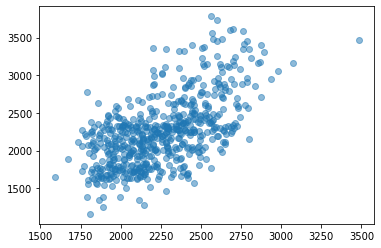

In [59]:
'''
Visually inspect linearity between target variable (y1) and predictions
'''
plt.plot(Y_prediction,y,'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

In [60]:
'''
Visually inspect the residuals to confirm normality
'''

'\nVisually inspect the residuals to confirm normality\n'

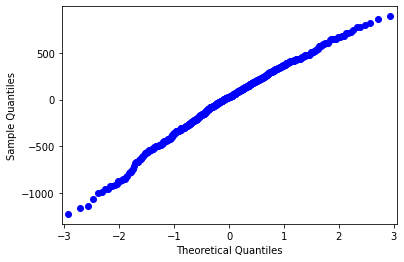

In [61]:
fig = sm.qqplot(residuals)

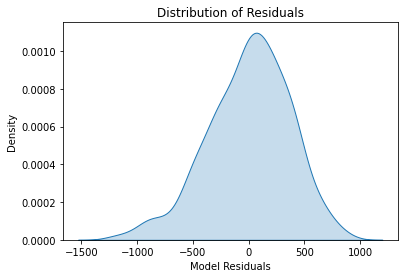

In [62]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

### 4.4) Absence of Multicollinearity

Tested and checked during data processing stage

###4.5) Homoscedasticity


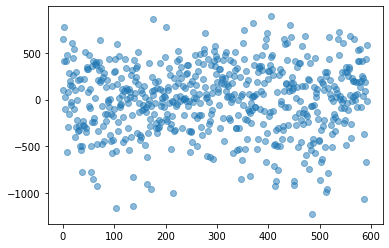

In [63]:
'''
Visually inspect residuals to confirm constant variance
'''
plt.plot(residuals,'o',alpha=0.5)
plt.show()